## PyTorch Examples:

More PyTorch examples and nn's in pure numpy 

In [73]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from numba import jit
import os
import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
sns.set_palette('muted',color_codes=True)
%matplotlib inline

In [35]:
# Quick numba demo 
def cholesky(A):
    """Return the Cholesky factorization, L, of the matrix A in the reals, such that A = LL^T.
    --------
    Args: A; a numpy 2d array (nxn) size
    --------
    Returns: L; a numpy 2d array, lower or upper triangular (nxn) size.
    """
    m,n = A.shape
    if m!=n:
        raise ValueError('Matrix must be square.')
    L = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            s = sum(L[i][k] * L[j][k] for k in range(j))
            if i==j:
                L[i][j] = np.sqrt(A[i][i] - s)
            else: 
                L[i][j] = (A[i][j] - s)/L[j][j]
    return L

@jit(nopython=True, nogil=True)
def fcholesky(A):
    """Return the Cholesky factorization, L, of the matrix A in the reals, such that A = LL^T.
    --------
    Args: A; a numpy 2d array (nxn) size
    --------
    Returns: L; a numpy 2d array, lower or upper triangular (nxn) size.
    """
    m,n = A.shape
    L = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            s = np.array([L[i][k] * L[j][k] for k in range(j)]).sum()
            if i==j:
                L[i][j] = np.sqrt(A[i][i] - s)
            else: 
                L[i][j] = (A[i][j] - s)/L[j][j]
    return L

In [41]:
from time import time 
arr = np.diag(np.random.randn(400))+4.2

t0 = time()
L = cholesky(arr)
te = time()-t0
print('Native Python time elapsed:',te)

t0 = time()
L = fcholesky(arr)
te = time()-t0
print('Numba time elapsed:',te)

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Native Python time elapsed: 6.503916025161743
Numba time elapsed: 0.031017065048217773


### Neural Net in pure Numpy 

In [7]:
np.random.seed(9901)
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    if t%100==99:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    

99 430.061507202
199 1.3311387951
299 0.00750869420989
399 5.42544485988e-05
499 4.76629433929e-07


### Neural net with just torch Tensors and autograd

#### You can also define your own functions like so:

In [12]:
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    def forward(self, input):
        """
        In the forward pass we receive a Tensor containing the input and return a
        Tensor containing the output. You can cache arbitrary Tensors for use in the
        backward pass using the save_for_backward method.
        """
        self.save_for_backward(input)
        return input.clamp(min=0)

    def backward(self, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

torch.manual_seed(1201)
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs, and wrap them in Variables.
x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)

# Create random Tensors for weights, and wrap them in Variables.
w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

learning_rate = 1e-6
for t in range(500):
    # Construct an instance of our MyReLU class to use in our network
    relu = MyReLU()

    # Forward pass: compute predicted y using operations on Variables; we compute
    # ReLU using our custom autograd operation.
    y_pred = relu(x.mm(w1)).mm(w2)
    # y_pred = model(x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t%100==99:
        print(t, loss.data[0])

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data

    # Manually zero the gradients after updating weights
    w1.grad.data.zero_()
    w2.grad.data.zero_()

99 932.1725463867188
199 8.434311866760254
299 0.14434002339839935
399 0.0034336342941969633
499 0.0002530073979869485


### Neural Net in TensorFlow: same as the above two

In [16]:
# First we set up the computational graph:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create placeholders for the input and target data; these will be filled
# with real data when we execute the graph.
x = tf.placeholder(tf.float32, shape=(None, D_in))
y = tf.placeholder(tf.float32, shape=(None, D_out))

# Create Variables for the weights and initialize them with random data.
# A TensorFlow Variable persists its value across executions of the graph.
w1 = tf.Variable(tf.random_normal((D_in, H)))
w2 = tf.Variable(tf.random_normal((H, D_out)))

# Forward pass: Compute the predicted y using operations on TensorFlow Tensors.
# Note that this code does not actually perform any numeric operations; it
# merely sets up the computational graph that we will later execute.
h = tf.matmul(x, w1)
h_relu = tf.maximum(h, tf.zeros(1))
y_pred = tf.matmul(h_relu, w2)

# Compute loss using operations on TensorFlow Tensors
loss = tf.reduce_sum((y - y_pred) ** 2.0)

# Compute gradient of the loss with respect to w1 and w2.
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])

# Update the weights using gradient descent. To actually update the weights
# we need to evaluate new_w1 and new_w2 when executing the graph. Note that
# in TensorFlow the the act of updating the value of the weights is part of
# the computational graph; in PyTorch this happens outside the computational
# graph.
learning_rate = 1e-6
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)

# Now we have built our computational graph, so we enter a TensorFlow session to
# actually execute the graph.
with tf.Session() as sess:
    # Run the graph once to initialize the Variables w1 and w2.
    sess.run(tf.global_variables_initializer())

    # Create numpy arrays holding the actual data for the inputs x and targets
    # y
    x_value = np.random.randn(N, D_in)
    y_value = np.random.randn(N, D_out)
    for t in range(500):
        # Execute the graph many times. Each time it executes we want to bind
        # x_value to x and y_value to y, specified with the feed_dict argument.
        # Each time we execute the graph we want to compute the values for loss,
        # new_w1, and new_w2; the values of these Tensors are returned as numpy
        # arrays.
        loss_value, _, _ = sess.run([loss, new_w1, new_w2],
                                    feed_dict={x: x_value, y: y_value})
        if t%100==99:
            print(t,loss_value)

99 606.503
199 2.66387
299 0.0227757
399 0.000547467
499 7.62659e-05


### Neural Net using Sequential and optim

In [17]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(size_average=False)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Variables it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t%100==99:
        print(t, loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 58.5325813293457
199 0.9637086391448975
299 0.0063652596436440945
399 3.196317265974358e-05
499 6.775528760272209e-08


### Custom Neural Net setup:

In [76]:
class DynamicNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(np.random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t%100==99:
        print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 19.427494049072266
199 0.12911784648895264
299 0.1356358379125595
399 0.05214390903711319
499 0.03809404373168945


### Faces data loading example

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]]


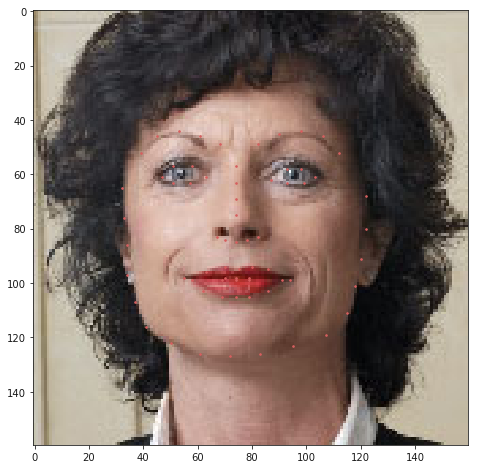

In [52]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize=(8,8))
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

### Override the Dataset class 

The only two methods that are mandatory for Dataset class override are the __len__() and __getitem__()

In [57]:
class FaceLandmarksData(Dataset):
    def __init__(self, fn, dirn, transform=None):
        self.landmarks_df = pd.read_csv(fn)
        self.root_dir = dirn
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_df.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_df.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


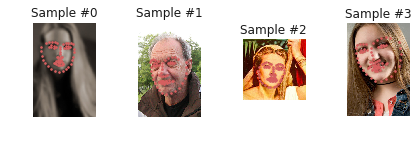

In [58]:
face_dataset = FaceLandmarksData(fn='data/faces/face_landmarks.csv',
                                    dirn='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### Custom Transforms

The custom transforms must be callable classes (i.e. the only method nesessary to override is the __call__() method.) Make sure to return the data in the same format you got it.

In [59]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

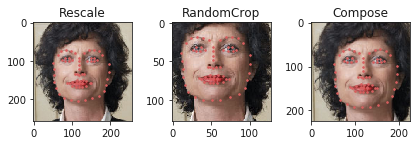

In [62]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [65]:
transformed_dataset = FaceLandmarksData(fn='data/faces/face_landmarks.csv',
                                           dirn='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### Dataloader class:

We are losing a lot of features in the above by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Loading the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


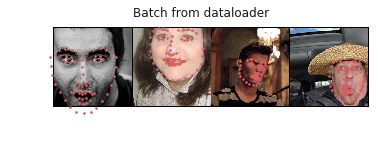

In [70]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break